In [1]:
# Necessary for the local package to work correctly
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import itertools
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, rdmolops

# Seaborn styling
sns.set_style('ticks')
sns.set_context('talk')

# 1. Inline plot
# 2. Print version
# 3. Notebook to reload external python modules
# 3.1 Reload modified code every time it is executed 
# 4. Retina (high resolution) plots
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
%watermark -u -n -t -z -v -m -g

last updated: Sun Sep 29 2019 09:53:06 EDT

CPython 3.5.4
IPython 6.1.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit
Git hash   : 7f97d0d52e5e9e9cb5f5e169615b7ea874125e3d


In [4]:
%watermark --iversions

numpy      1.13.3
seaborn    0.9.0
rdkit      2017.09.1
json       2.0.9
pandas     0.20.3
matplotlib 2.0.2



In [46]:
def construct_pos_matrix(mol, out_size=-1):
    """Construct relative positions from each atom within the molecule.

    Params:
    -------
    mol: rdkit.Chem.Mol
        Molecule of interest.
    """
    N = mol.GetNumAtoms()
    coords = mol.GetConformer().GetPositions() # shape=(N,3)

    # Determine correct output size based on atoms. Useful to generate feature matrix of same 
    # size for all mols.
    if out_size < 0:
        size = N
    elif out_size > N:
        size = out_size
    else:
        raise ValueError('`out_size` (N={}) is smaller than number of atoms in mol (N={})'.
                         format(out_size, N))
    
    pos_matrix = np.zeros(shape=(size, size, 3), dtype=np.float)
    for atom_idx in range(N):
        atom_pos = coords[atom_idx] # central atom of interest
        for neighbor_idx in range(N):
            neigh_pos = coords[neighbor_idx] # neighboring atom
            pos_matrix[atom_idx, neighbor_idx] = atom_pos - neigh_pos # dist between neighbor -> center
    return pos_matrix

In [47]:
mols = Chem.SDMolSupplier('../data/processed/vdgv570-constraints=1-algo=ETKDG.sdf')

pos_matrix = construct_pos_matrix(mols[0], out_size=10)
sns.heatmap(pos_matrix[:,:,0], cmap='Greens')

ValueError: `out_size` (N=10) is smaller than number of atoms in mol (N=34)

In [24]:
smiles = 'N[C@@]([H])([C@]([H])(O2)C)C(=O)N[C@@]([H])(CC(=O)N)C(=O)N[C@@]([H])([C@]([H])(O)C)C(=O)N[C@@]([H])(Cc1ccc(O)cc1)C(=O)2'
mol = Chem.MolFromSmiles(smiles)

adj = rdmolops.GetAdjacencyMatrix(mol)
s1, s2 = adj.shape

# padded_mol_feats = np.zeros((49, 49), dtype=np.float)
# padded_mol_feats[:s1, :s2] = np.array(adj, dtype=np.float)
# adj = padded_mol_feats

adj = adj + np.eye(s1, dtype=np.float64)
degree = np.array(adj.sum(1))
deg_inv_sqrt = np.power(degree, -0.5)
deg_inv_sqrt[np.isinf(deg_inv_sqrt)] = 0.
deg_inv_sqrt = np.diag(deg_inv_sqrt)

padded_mol_feats = np.zeros(shape=(49,49), dtype=np.float)
padded_mol_feats[:s1, :s2] = deg_inv_sqrt
deg_inv_sqrt = padded_mol_feats

In [25]:
deg_inv_sqrt

array([[ 0.70710678,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.5       ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

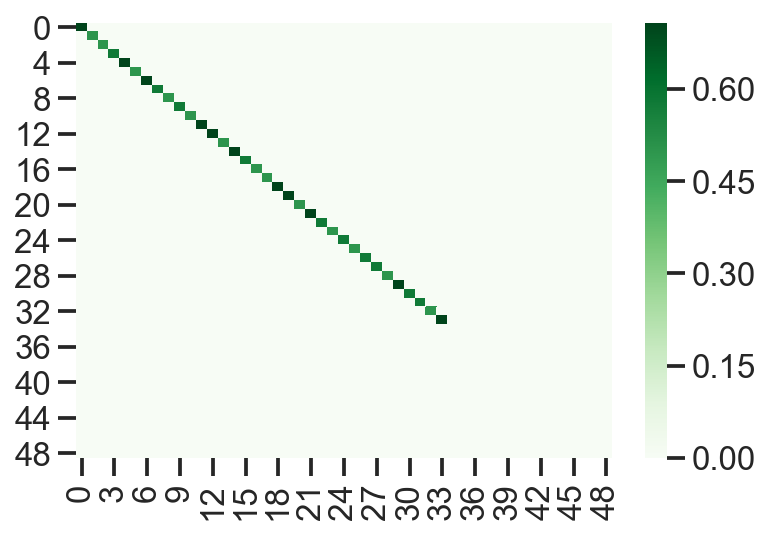

In [26]:
sns.heatmap(deg_inv_sqrt, cmap='Greens')

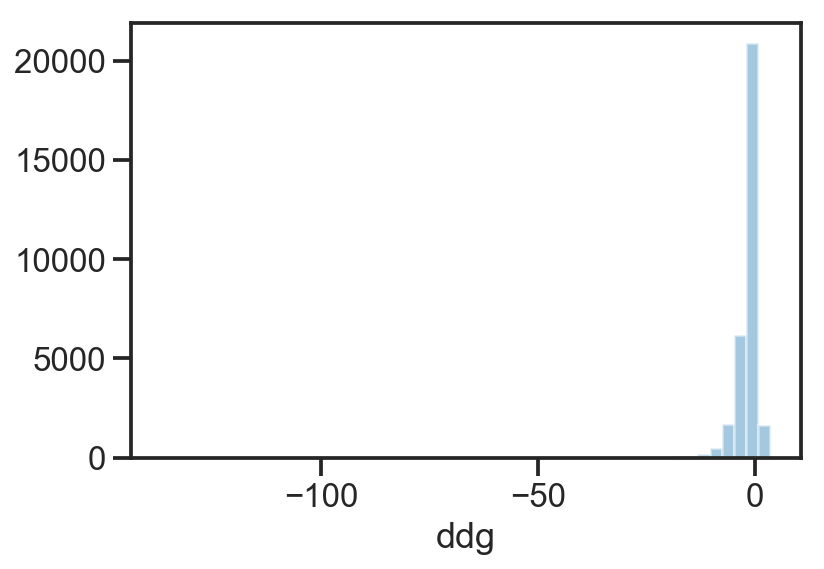

In [31]:
ddg = pd.read_csv('../data/raw/ddg.csv', sep=',')
sns.distplot(ddg['ddg'], kde=False)

In [32]:
ddg.head()

,protein,mut_consecutive,mut_rosetta,ddg
0,2LZM,M1A,M1A,-1.58403
1,2LZM,M1R,M1R,-2.66589
2,2LZM,M1N,M1N,-1.83711
3,2LZM,M1D,M1D,-3.38751
4,2LZM,M1C,M1C,-1.91121


In [33]:
mean = np.mean(ddg['ddg'])
std = np.std(ddg['ddg'])
print('mean: {}, std: {}'.format(mean, std))

mean: -1.6270793806921675, std: 3.5824362876883575


Remove the above, just for testing

In [13]:
df = pd.read_csv("../data/raw/vdgv570.csv", sep=',')
df.head(n=10)

,ID,Variants,Fitness
0,133462,TNTY,0.0
1,30784,APPP,0.0
2,130974,TFFM,0.0
3,9290,IDMW,0.0
4,43174,DRNQ,0.0
5,101152,NPYI,0.0
6,45144,EAQQ,0.0
7,104378,PEKW,0.0
8,4899,ECIV,0.0
9,19282,TPIV,0.0


## Distribution of fitness for the given dataset

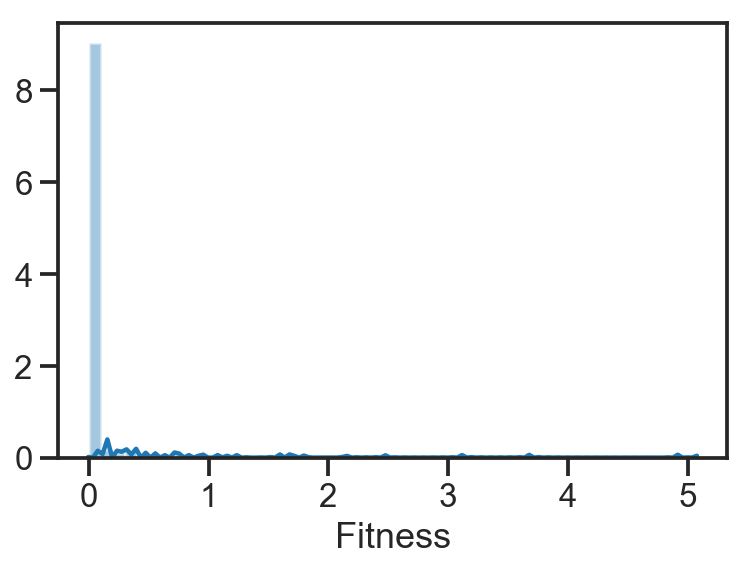

In [22]:
fitness = df['Fitness']
sns.distplot(fitness, bins=50, kde=False)

## Plot fitness map
We want to plot the fitness of the protein for discrete variants of 4 amino acids, which come from a subset of the sequence -> fitness dataset. Convert the sequence to a 2x2 representation so that we can plot it. i.e TNTY -> TN, TY on the x and y axis, respectively. This way we can view both (a) the sparsity of the fitness data we are given and (b) the fitness landscape.   

In [14]:
def generate(n=4):
    """
    Generate all possible combinations of n length amino acid sequence. 
    
    Example:
    --------
    >>> combs = generate(n=2)
    ['AA', 'AR', 'AN', 'AD', ..., 'VV']
    """
    acids = ['A', 'R', 'N', 'D', 'C', 
             'Q', 'E', 'G', 'H', 'I', 
             'L', 'K', 'M', 'F', 'P', 
             'S', 'T', 'W', 'Y', 'V']
    combs = list(itertools.product(acids, repeat=n))
    return np.array(["".join(comb) for comb in combs])

In [15]:
combs = generate(n=2)
fitness_df = pd.DataFrame(0.0, index=combs, columns=combs)
fitness_df.head()

,AA,AR,AN,AD,AC,AQ,AE,AG,AH,AI,...,VL,VK,VM,VF,VP,VS,VT,VW,VY,VV
AA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
for idx, row in df.iterrows():
    variant = row['Variants']
    x,y = variant[:2], variant[2:]
    fitness_df.at[x,y] = row['Fitness']

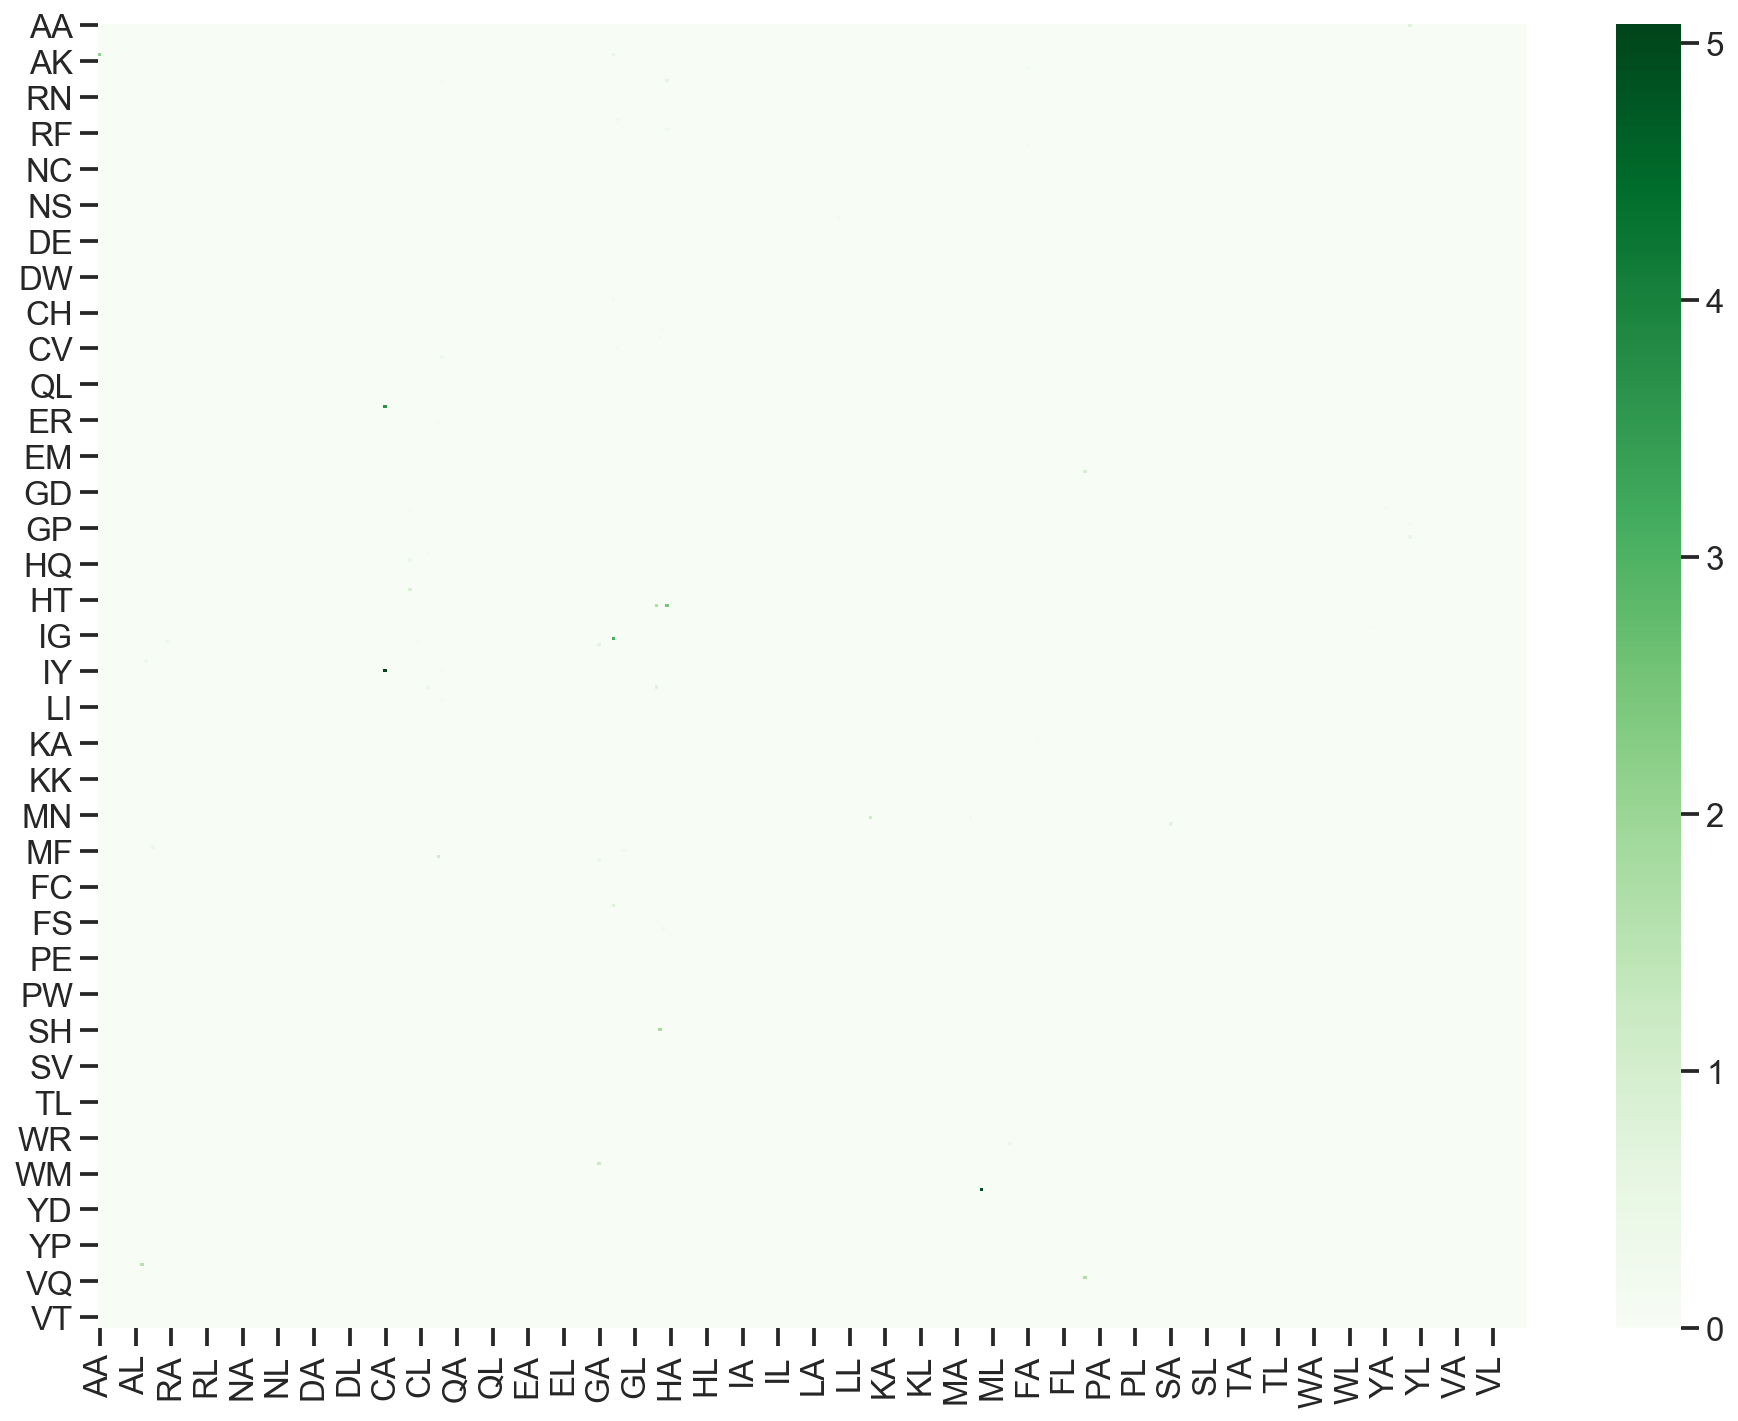

In [17]:
plt.figure(figsize=(16,12))
sns.heatmap(fitness_df, cmap='Greens')

## Determine if there is a correlation between hamming distance (string difference between the parental evolved sequence) and its fitness ratio
Chemically, is the sequences that have a different chemical makeup in different locations affect the fitness of the evolved sequence. For example, non-polar substitutions with another non-polar sequence would allow for similar fitness. 

For the second task, what about the directed evolution. Wouldn't knowing which sequences are those sequences make a difference out prediction accuracy. 

In [18]:
def hamming_dist(s1, s2):
    """
    Determine the number of positions/chars it takes 
    to get from the first string to the second. 
    
    Params:
    -------
    s1: str
    s2: str
        The strings to compare.
    
    Returns:
    --------
    dist: int
        The distance between the strings. 
    """
    assert len(s1) == len(s2)
    return len([True for ch1,ch2 in zip(s1,s2) if ch1 != ch2])

def compute_distance(row):
    return hamming_dist(row['Variants'], 'VDGV')

In [19]:
df['Hamming'] = df.apply(compute_distance, axis=1)
df.head(n=10)

,ID,Variants,Fitness,Hamming
0,133462,TNTY,0.0,4
1,30784,APPP,0.0,4
2,130974,TFFM,0.0,4
3,9290,IDMW,0.0,3
4,43174,DRNQ,0.0,4
5,101152,NPYI,0.0,4
6,45144,EAQQ,0.0,4
7,104378,PEKW,0.0,4
8,4899,ECIV,0.0,3
9,19282,TPIV,0.0,3


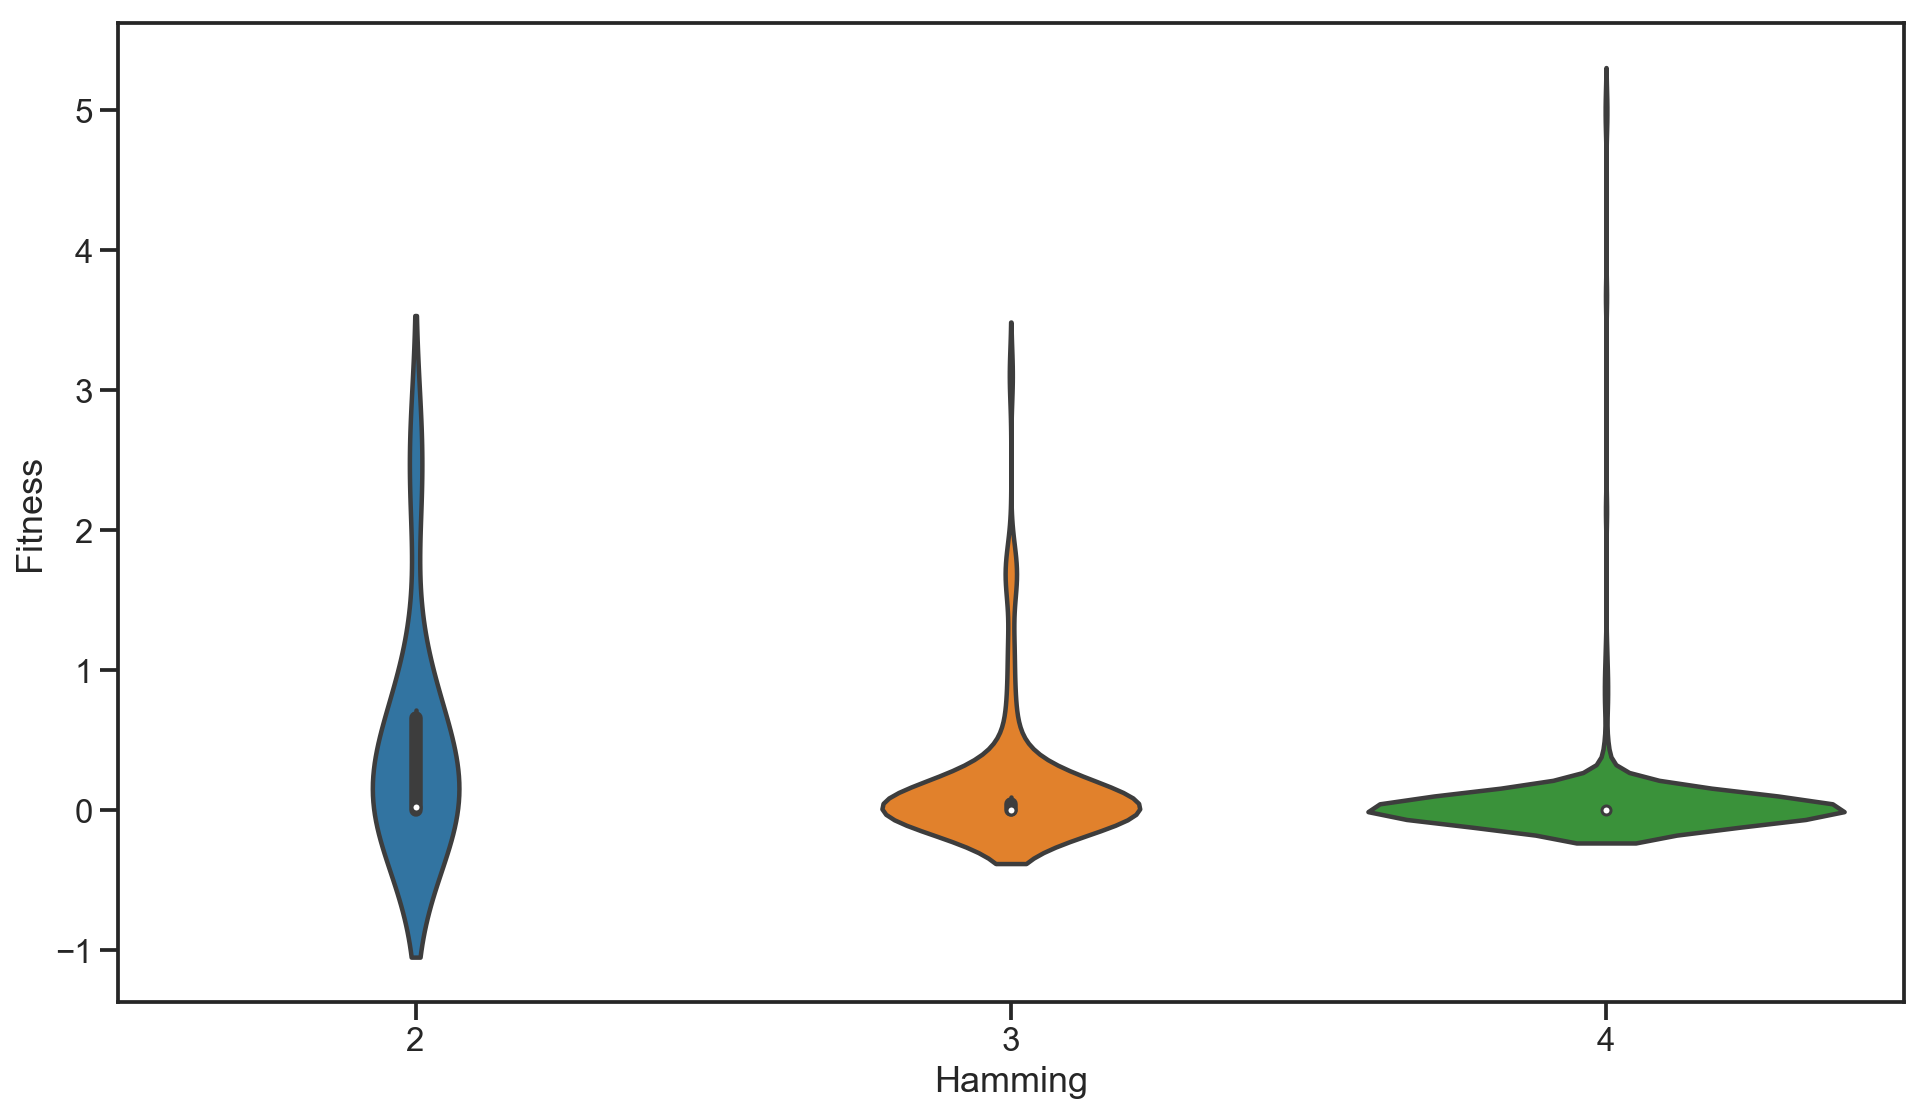

In [20]:
plt.figure(figsize=(16,9))
sns.violinplot(x="Hamming", y="Fitness", data=df)